# Introduction
We focus on ambulance diversions in the emergency department (ED) as a prototype example to illustrate how data-adaptive decision-making, via the proposed digital twinning approach, can lead to better mortality outcomes. Diverting ambulances aims to reduce ED overcrowding and balance patient load among multiple EDs. However, setting a static policy, such as diverting only when the number of patients in the ED (queue) exceeds a prespecified threshold, can be highly suboptimal during surge situations, because the threshold used in normal situations can perform poorly in the latter cases. If we can adaptively change the threshold level by assimilating and optimizing according to the predicted surge, we could more effectively avoid overcrowding and potentially save lives. This simple prototype example showcases the mortality improvement using such a data-adaptive threshold policy. In particular, the optimization of this data-adaptive policy requires running system simulation for the mortality outcomes from each hospital. This simulation model resembles the proposed digital twins that are envisioned to build at a much larger scale. Moreover, in this example, a simulation run of each trajectory to output the mortality outcome already takes ~4 hours on a computer with an Intel Core i5-8250U CPU and 8GB RAM. Optimizing an adaptive policy at each threshold-changing opportunity would require running a sufficient number (e.g., 100) of trajectories to wash out the simulation error, as well as evaluating a wider grid of threshold values for performance comparison, thus altogether leading to over 500 hours. This motivates us to investigate a metamodeling of the digital twin via a computationally much lighter AI model that can be optimized more straightforwardly, thus leading to an overall AI-digital-twinning integrative approach.

# Simulation Model
The simulation model consists of two emergency departments (labeled ED-1 and ED-2), each with their own physicians and patients. We model patient death time as a logistic function with parameters dependent on the patient’s triage level and wait time (see Figure 1), with slightly perturbed parameters for each patient. Data from [Lin et al (2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3950617/#Sec8), [Chowdhury et al (2018)](https://www.physicianleaders.org/articles/queuing-theory-reducing-wait-stay), and [Wrede et al (2020)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7699806/) were used to estimate average hourly arrival rates, triage probabilities, and service rates (physician times), which were assumed to only depend on the triage level (see Table 1). Arrival rates and service rates were assumed to be exponentially distributed. A weekday multiplier was also added to the arrival rate. 25% of arrivals were assumed to be by ambulance and the other 75% were assumed to be walk-ins. The same values were used for both emergency departments. 

According to the [American Academy of Emergency Medicine](https://www.aaem.org/statements/position-statement-on-emergency-physician-to-patient-ed-staffing-ratios/), there must be at least one physician for every 2.5 patients per hour. Based on the estimated hourly arrival rates, this requirement is satisfied by the physician schedule used for ED-1 below. For ED-2, 4 additional physicians (27%) were scheduled compared to ED-1 (since this ED will be receiving patients that arrive by ambulance but are diverted from ED-1).

Physicians are assumed to begin serving any type of patient arriving between the start of their shift to the end of their shift (and so may finish after the end of their shift if they are still attending to a patient). Furthermore, they are assumed to serve the highest priority (triage level) patient in the queue, otherwise they will serve the first patient that arrives if the queue is empty. Finally, if a patient with a triage level of 1 arrives and all physicians are busy, the physician serving the lowest priority patient will stop and attend to the patient that has just arrived first, unless all physicians are serving patients with a triage level of 1.

In [2]:
import numpy as np
import pandas as pd 
from functions import *

# parameters ('crisis' and 'surge' are used interchangeably)
np.random.seed(2)
days = 7*4
thresholds = np.linspace(0, 300, 16)
hosp2_doctor_shift_counts = [3, 3, 4, 3, 4, 2] # [3, 3, 4, 3, 4, 2] 
weekly_crisis_factor = [1., 3., 3., 1.] # set all 1 if no surge/crisis 
assert(len(weekly_crisis_factor) == days // 7)
reps = 1 # increase for repeated runs of simulation

hourly_arrival_rates_ = [3.12,2.54,2.33,2.33,2.63,3.21,4.61,6.73,9.08,11.46,11.76,10.97,11.25,10.27,11.46,11.36,11.08,10.43,10.04,9.57,8.31,7.03,5.12,5.05]
weekday_multiplier = [1.03, 0.97, 0.92, 0.94, 1., 1.06, 1.08]
hourly_arrival_rates = [h * weekday_multiplier[d % 7] * weekly_crisis_factor[d // 7] for d in range(days) for h in hourly_arrival_rates_] + [0]
triage_probabilities = [0.0099, 0.0874, 0.4951, 0.3777, 0.0299] # highest to lowest priority
triage_probabilities_crisis = [0.1498, 0.2761, 0.3196, 0.2297, 0.0248] 
service_rate = np.array([1.3, 1.25, 0.8, 0.45, 0.3]) 
patience = np.array([np.inf, np.inf, 6, 5, 4])

patients_hosp1 = generate_patients(hourly_arrival_rates, service_rate, patience, triage_probabilities, triage_probabilities_crisis, weekly_crisis_factor, hosp_number=1)
patients_hosp2 = generate_patients(hourly_arrival_rates, service_rate, patience, triage_probabilities, triage_probabilities_crisis, weekly_crisis_factor, hosp_number=2)

##### Figure 1. CDF of patient death time at different triage levels. Each patient will have a slightly different mortality curve within an interval according to their triage. Patients leave the queue if they die or their patience runs out.

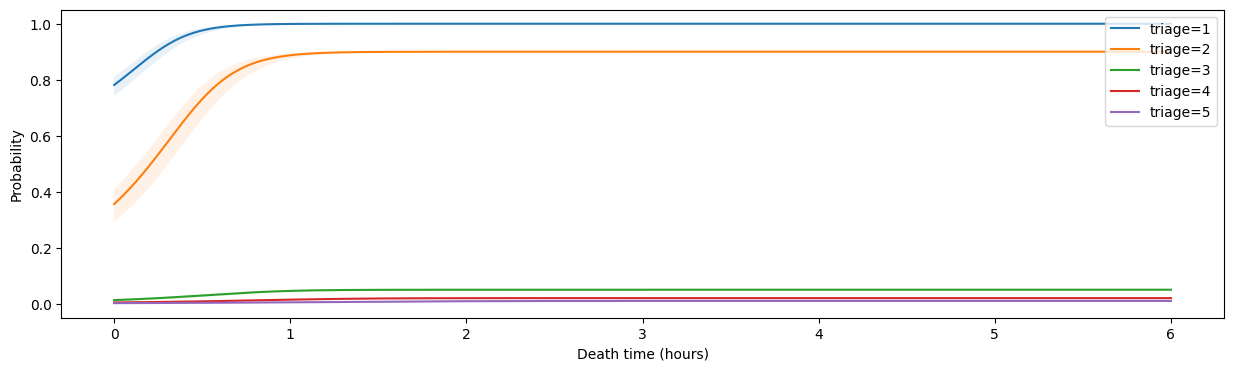

In [2]:
plot_mortality()

##### Figure 2. Hourly arrival rate of patients during the week.

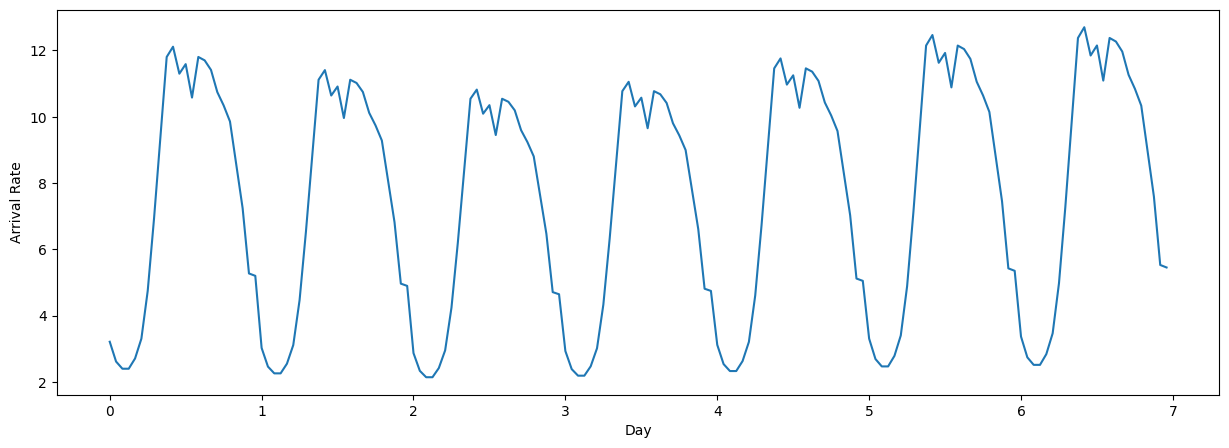

In [3]:
plot_arrival_rate(hourly_arrival_rates[:24*7])

##### Table 1. Input parameters based on triage level.

In [3]:
pd.DataFrame({
    'Triage Level': [1, 2, 3, 4, 5], 
    'Proportion (Normal)': triage_probabilities, 
    'Proportion (Surge)': triage_probabilities_crisis, 
    'Service Rate': service_rate, 
    'Patience': patience
    })

,Triage Level,Proportion (Normal),Proportion (Surge),Service Rate,Patience
0,1,0.0099,0.1498,1.30,inf
1,2,0.0874,0.2761,1.25,inf
2,3,0.4951,0.3196,0.80,6.0
3,4,0.3777,0.2297,0.45,5.0
4,5,0.0299,0.0248,0.30,4.0


# Results

We first show the performance of a static policy, using a single prespecified threshold value for the number of patients in ED-1’s queue which, if exceeded, leads to the diversion of all patients that would have arrived at ED-1 by ambulance to ED-2. We assume that this leads to an increase in travel time of one minute. With perfect information of the input values, such as arrival rates, physician times, and our mortality function, we can apply our simulation to a normal scenario over a four week period, with hourly arrival rates seen in Figure 2, and a surge scenario, where the arrival rate is tripled in the second and third weeks, with changes to triage level proportions as well (see Figure 4 and Table 1). The threshold of 20 under the normal scenario leads to an optimal 5.80% mortality rate, yet under the surge scenario, it leads to the worst possible mortality rate of 25.02% (see Figure 5).

We then show the performance of a data-adaptive threshold policy where thresholds can change at the beginning of each shift (i.e., every 4 hours) during the simulation period (see Figure 6). To determine the optimal threshold at the start of each shift, we repeatedly simulate ED arrivals until the end of our time horizon (4 weeks in our example) at a grid of threshold values and choose the threshold that leads to the lowest mortality. Using this data-adaptive threshold policy, we obtain an improved mortality rate of 24.83%, or approximately 10 lives saved across both hospitals, during the surge scenario. For larger-scale problems, we expect more significant improvements in mortality outcomes, and using AI to approximate the simulation model or the end-to-end adaptive policies would achieve these improvements in a practically implementable manner.


##### Figure 4. Hourly arrival rate in the surge scenario where a surge in arrivals occurs in weeks 2 and 3.

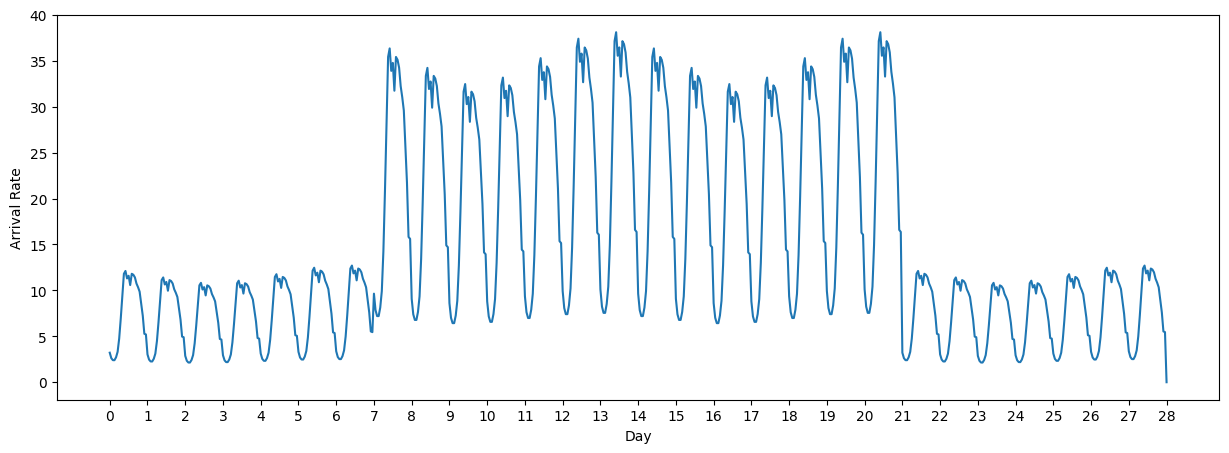

In [5]:
plot_arrival_rate(hourly_arrival_rates)

##### Figure 5. Mortality rate at different thresholds for the normal (top) and surge (bottom) scenarios. The simulation model was run for a period of 4 weeks.

Threshold: 0.0 --- Mortality rate: 0.0587
Threshold: 20.0 --- Mortality rate: 0.058
Threshold: 40.0 --- Mortality rate: 0.0588
Threshold: 60.0 --- Mortality rate: 0.0591
Threshold: 80.0 --- Mortality rate: 0.0589
Threshold: 100.0 --- Mortality rate: 0.0589
Threshold: 120.0 --- Mortality rate: 0.0589
Threshold: 140.0 --- Mortality rate: 0.0589
Threshold: 160.0 --- Mortality rate: 0.0589
Threshold: 180.0 --- Mortality rate: 0.0589
Threshold: 200.0 --- Mortality rate: 0.0589
Threshold: 220.0 --- Mortality rate: 0.0589
Threshold: 240.0 --- Mortality rate: 0.0589
Threshold: 260.0 --- Mortality rate: 0.0589
Threshold: 280.0 --- Mortality rate: 0.0589
Threshold: 300.0 --- Mortality rate: 0.0589


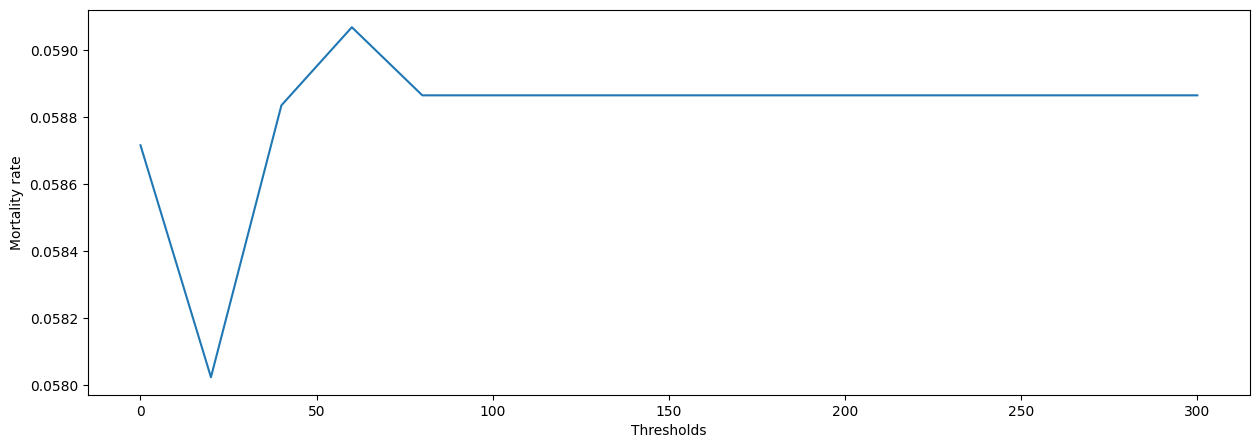

In [11]:
normal_crisis_factor = [1., 1., 1., 1.]
single_threshold_simulation(
    patients_hosp1,
    patients_hosp2,
    hourly_arrival_rates=[h * weekday_multiplier[d % 7] * normal_crisis_factor[d // 7] for d in range(days) for h in hourly_arrival_rates_] + [0], 
    service_rate=service_rate, 
    patience=patience, 
    triage_probabilities=triage_probabilities, 
    triage_probabilities_crisis=triage_probabilities_crisis,
    weekly_crisis_factor=normal_crisis_factor,
    thresholds=thresholds, 
    reps=reps,
    days=days,
    hosp2_doctor_shift_counts=hosp2_doctor_shift_counts,
    )

Threshold: 0.0 --- Mortality rate: 0.2486
Threshold: 20.0 --- Mortality rate: 0.2504
Threshold: 40.0 --- Mortality rate: 0.2495
Threshold: 60.0 --- Mortality rate: 0.248
Threshold: 80.0 --- Mortality rate: 0.2491
Threshold: 100.0 --- Mortality rate: 0.2492
Threshold: 120.0 --- Mortality rate: 0.2478
Threshold: 140.0 --- Mortality rate: 0.2476
Threshold: 160.0 --- Mortality rate: 0.2483
Threshold: 180.0 --- Mortality rate: 0.2476
Threshold: 200.0 --- Mortality rate: 0.2481
Threshold: 220.0 --- Mortality rate: 0.2488
Threshold: 240.0 --- Mortality rate: 0.2483
Threshold: 260.0 --- Mortality rate: 0.2482
Threshold: 280.0 --- Mortality rate: 0.2482
Threshold: 300.0 --- Mortality rate: 0.2482


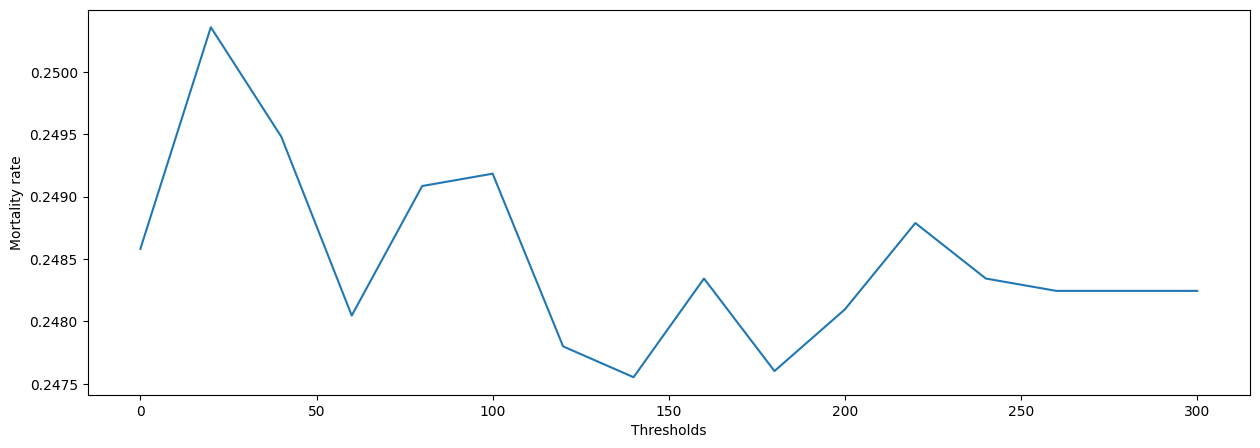

In [7]:
single_threshold_simulation(
    patients_hosp1,
    patients_hosp2,
    hourly_arrival_rates=hourly_arrival_rates, 
    service_rate=service_rate, 
    patience=patience, 
    triage_probabilities=triage_probabilities, 
    triage_probabilities_crisis=triage_probabilities_crisis,
    weekly_crisis_factor=weekly_crisis_factor,
    thresholds=thresholds, 
    reps=reps,
    days=days,
    hosp2_doctor_shift_counts=hosp2_doctor_shift_counts,
    )

##### Figure 6. Threshold values for the surge scenario when when simulating until the end of the planning period.

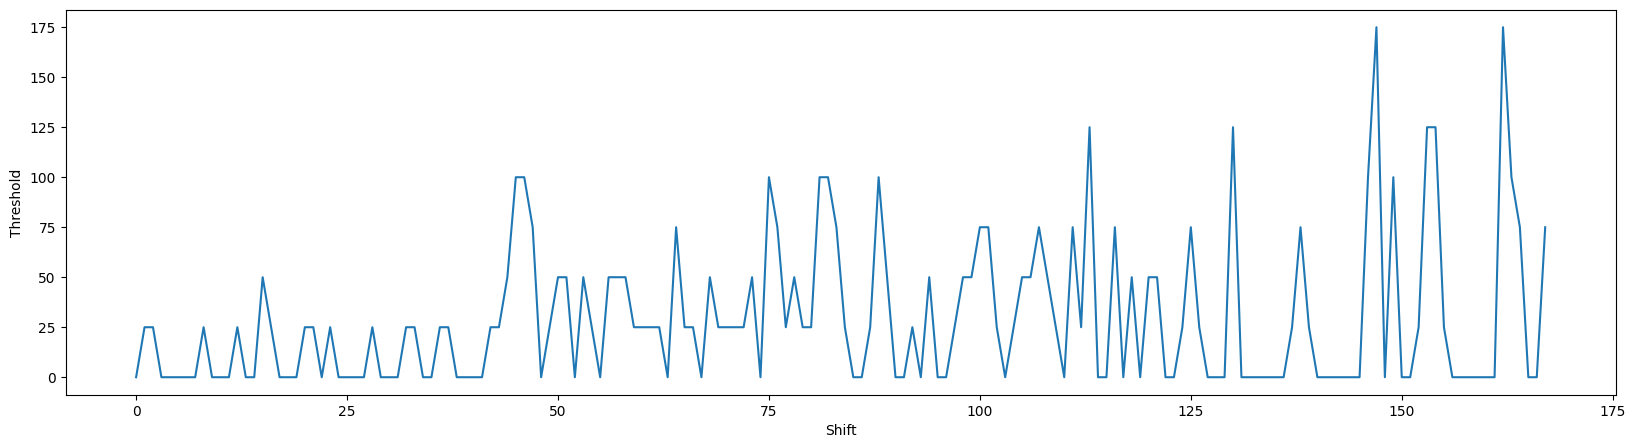

In [12]:
# takes a long time to run
varying_threshold_simulation(
    hourly_arrival_rates, 
    service_rate, 
    patience, 
    triage_probabilities, 
    triage_probabilities_crisis, 
    weekly_crisis_factor, days, 
    patients_hosp1, 
    patients_hosp2, 
    hosp2_doctor_shift_counts
    )